In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.special import legendre
import scipy.sparse.linalg as sp
import seaborn as sns
from rich import *
from tqdm import tqdm
from types import FunctionType as function
from matplotlib.colors import LogNorm
from matplotlib import rcParams

sns.set()
sns.set_style("whitegrid")
rcParams['font.family'] = 'serif'

In [2]:
def do_op(f, xs):
    """
    `do_op(f, xs)` 

    Performs function `f` to every component of `xs` and returns the results in a vector.

    ### Parameters:
    `f`: a function that takes a scalar as input and returns a scalar.
    `xs`: a vector of scalars.

    ### Return:
    `results`: a vector of scalars, the result of applying `f` to every component of `xs`.
    """ 
    results = np.zeros(len(xs))
    for i in range(len(xs)):
        results[i] = f(xs[i])
    return results

# Problem setup
L:float     = 1.0  # Domain bounds
N:int       = 20  # Number of elements
p:int       = 4  # Polynomial degree
f:function  = lambda x: np.sin(2*np.pi*x)  # RHS function

class Grid:
    def __init__(self, L, N, alphas, positions):
        """
        `mesh_generator(L, N, alphas, positions)`
        
        Generate a cut-cell mesh in a 1D domain of length `L` with `N` elements.

        ### Parameters:
        `L`: length of the domain.
        `N`: Number of elements.
        `alphas`: a list containing the relative size of the cut cells (alpha \in [0,1]).
        `positions`: a list containing the positions of the cut cells (position \in [0,N]).

        ### Return:
        `nodes`: a 2D array of shape (2, N) containing the left and right nodes of the mesh.
        `h`: a scalar containing the full cell width.
        `h_local`: a 1D array of size N containing the width of each element.
        """
        assert np.size(alphas) == np.size(positions), "Incompatible size of alphas and positions"
        h = L / (N - np.size(alphas) + np.sum(alphas)) # global cell width
        nodes = np.linspace(0, N, N + 1) * h
        for i in range(np.size(alphas)):
            nodes[positions[i]:] -= h * (1-alphas[i])
        h_local = np.diff(nodes)
        nodes = np.array([nodes[0:-1], nodes[1:]])
            
        self.nodes = nodes # a 2D array of shape (2, N) containing the left and right nodes of the mesh.
        self.h = h
        self.h_local = h_local # a 1D array of size N containing the width of each element.
        self.L = L
        self.N = N
        
    def preprocess(self, merge_type="central"):
        """
        `preprocess(nodes, h_local, h)`
        
        Preprocess the mesh to prepare for state redistribution.
        
        ### Parameters:
        `nodes`: a 2D array of shape (2, N) containing the left and right nodes of the mesh.
        `h_local`: a 1D array of size N containing the width of each element.
        `h`: a scalar containing the full cell width.
        
        ### Return:
        `merged_nodes`: a 2D array of shape (2, N) containing the left and right nodes of the mesh after merging small cells.
        `overlap`: a list of lists, where each inner list contains the indices of the merged cells that overlap on each original cell.
        `merged_ind`: a list of lists, where each inner list contains the indices of the original cells are covered by each merged cell.
        """
        merged_nodes = np.zeros(np.shape(self.nodes))
        merged_ind = []
        overlap = [ [] for _ in range(self.N) ]
        for i in range(self.N):
            ind = []
            if self.h_local[i] >= 0.5 * self.h:
                merged_nodes[:, i] = self.nodes[:, i]
                overlap[i].append(i)
                ind.append(i)
            else: # not sure: what if two or more small cut cells are close?
                if merge_type != "right":
                    merged_nodes[0, i] = self.nodes[0, (i-1) % self.N]
                    overlap[(i-1) % self.N].append(i)
                    ind.append((i-1) % self.N)
                else:
                    merged_nodes[0, i] = self.nodes[0, i]

                overlap[i].append(i)
                ind.append(i)
                
                if merge_type != "left":
                    merged_nodes[1, i] = self.nodes[1, (i+1) % self.N]
                    overlap[(i+1) % self.N].append(i)
                    ind.append((i+1) % self.N)
                else:
                    merged_nodes[1, i] = self.nodes[1, i]
            
            merged_ind.append(ind)
            
        self.merged_nodes = merged_nodes
        self.overlap = overlap
        self.merged_ind = merged_ind
        self.overlap_counts = np.int64(do_op(len, overlap)) # a 1D array of size N containing the number of merged cells that overlap on each original cell.
    
    def weighted_inner(self, f:function, g:function, ind):
        """
        `weighted_inner(f, g, ind, h_local, overlap_counts, nodes)`
        
        Performs a weighted inner product between two functions `f` and `g` on the merged mesh cell which covers the original cells that are indexed by `ind`.
        
        ### Parameters:
        `f`: a function that takes a scalar as input and returns a scalar.
        `g`: a function that takes a scalar as input and returns a scalar.
        `ind`: the index of the list containing the indices of the original cells that are covered by the merged cell.
        `grid`: a grid object containing the corresponding grid informations.
        
        ### Return:
        `result`: a scalar, the weighted inner product between `f` and `g` on the merged mesh cell.
        """
        H = 0
        result = 0
        func = lambda x: f(x) * g(x)
        for i in self.merged_ind[ind]:
            H += self.h_local[i] / self.overlap_counts[i]
            result += integrate.quad(func, self.nodes[0, i], self.nodes[1, i])[0] / self.overlap_counts[i]
        return result / H

    def find_basis(self, ind, p):
        """
        `find_basis(ind, h_local, overlap_counts, nodes, p)`
        
        Performs Gram-Schmidt to find the basis functions for the merged mesh cell which covers the original cells that are indexed by `ind`.
        
        ### Parameters:
        `ind`: the index of the list containing the indices of the original cells that are covered by the merged cell.
        `grid`: a grid object containing the corresponding grid informations.
        `p`: a scalar, the polynomial degree.
        
        ### Return:
        `Polys`: a list of functions, the basis functions for the merged mesh cell.
        """
        Polys = []
        for i in range(p+1):
            Pi = legendre(i)
            for j in range(i):
                Pi = Pi - Polys[j] * self.weighted_inner(Pi, Polys[j], ind)
            Pi = Pi / np.sqrt(self.weighted_inner(Pi, Pi, ind))
            Polys.append(Pi)
        return Polys
    
    def find_local_basis(self, p):
        """
        `find_local_basis(merged_ind, h_local, overlap_counts, nodes, p)`
        
        Find the basis function for each merged cell.
        
        ### Parameters:
        `grid`: a grid object containing the corresponding grid informations.
        `p`: a scalar, the polynomial degree.
        
        ### Return:
        `local_basis`: a list of lists, where each inner list contains the basis functions for each merged cell.
        """
        local_basis = []
        for i in range(self.N):
            local_basis.append(self.find_basis(i, p))
        self.local_basis = local_basis
    

grid = Grid(L, N, [1/12, 1/4], [N//2-1, N//2+1])
grid.preprocess()
grid.find_local_basis(p)

In [3]:
def initialize(f, grid, p):
    """
    `initialize(f, nodes, h_local, p)`
    
    Initialize the solution $u_0(x)$ using the given initial condition `f`.
    
    ### Parameters:
    `f`: a function that takes a scalar as input and returns a scalar.
    `grid`: a grid object containing the corresponding grid informations.
    `p`: a scalar, the polynomial degree.
    
    ### Return:
    `U`: a 2D array of shape (N, p+1) containing the coefficients of the basis functions.
    """
    U = np.zeros((grid.N, p+1))
    for i in range(grid.N):
        for j in range(p+1):
            # Legendre polynomial normalization factor
            phi = lambda x: np.sqrt((2*j+1)/grid.h_local[i]) * legendre(j)(2*(x - (grid.nodes[0, i] + grid.nodes[1, i]) / 2) / grid.h_local[i])
            # Adjusted function for projection onto the j-th Legendre polynomial
            func = lambda x: f(x) * phi(x)
            # Project and normalize
            U[i, j] = integrate.quad(func, grid.nodes[0, i], grid.nodes[1, i])[0]
    return U

def evaluate_sol(U, grid):
    """
    `evaluate_sol(U, grid)`
    
    Returns a function `f` which takes in the position `x` and evaluates the solution value at that point.
    
    ### Parameters:
    `U`: a 2D array of shape (N, p+1) containing the coefficients of the basis functions.
    `grid`: a grid object containing the corresponding grid informations.
    
    ### Return:
    `f`: a function that takes in the position `x` and evaluates the solution value at that point.
    """
    def f(x):
        u = 0
        index = 0
        while x > grid.nodes[1, index]:
            index += 1
        coeffs = U[index, :]
        psi = (x - (grid.nodes[0, index] + grid.nodes[1, index]) / 2) * 2 / grid.h_local[index]
        for j in range(p+1):
            u += np.sqrt((2*j+1)/grid.h_local[index]) * legendre(j)(psi) * coeffs[j]
        return u
    return f

In [4]:
def get_coarsen_M(p, grid):
    coarsen_M = []
    N = len(grid.overlap_counts)
    for i in range(N):
        M = np.zeros((p+1, (p+1) * len(grid.merged_ind[i])))
        H = 0
        for K in range(len(grid.merged_ind[i])):
            k = grid.merged_ind[i][K]
            H += grid.h_local[k] / grid.overlap_counts[k]
            for j in range(p+1):
                merged_basis = grid.local_basis[i][j]            
                for l in range(p+1):
                    unmerged_basis = lambda x: np.sqrt((2*l+1)/grid.h_local[k]) * legendre(l)(2*(x - (grid.nodes[0, k] + grid.nodes[1, k]) / 2) /grid.h_local[k])
                    func = lambda x: merged_basis(x) * unmerged_basis(x)
                    M[j, K * (p+1) + l] = integrate.quad(func, grid.nodes[0, k], grid.nodes[1, k])[0] / grid.overlap_counts[k]
        coarsen_M.append(M / H)
    return coarsen_M

def Coarsen(U, grid, p, coarsen_M):
    """
    `Coarsen(U, merged_ind, p, coarsen_M)`
    
    Performs the coarsening step of the state redistribution method.
    
    ### Parameters:
    `U`: a 2D array of shape (N, p+1) containing the coefficients of the basis functions.
    `merged_ind`: a list of lists, where each inner list contains the indices of the original cells that are covered by each merged cell.
    `p`: a scalar, the polynomial degree.
    `coarsen_M`: a list of local coarsening matrices, where each local coarsening matrix is a matrix of shape (p+1, (p+1) * len(merged_ind[i])).
    
    ### Return:
    `Q`: a 2D array of shape (N, p+1) containing the coefficients of the basis functions on the merged cells.
    """
    Q = np.zeros(np.shape(U))
    for i in range(N):
        c = np.zeros((p+1) * len(grid.merged_ind[i]))
        for K in range(len(grid.merged_ind[i])):
            k = grid.merged_ind[i][K]
            c[K * (p+1): (K+1) * (p+1)] = U[k, :]
        Q[i, :] = coarsen_M[i] @ c
    return Q

def get_redistribute_M(p, grid):
    redistribute_M = []
    N = len(grid.overlap_counts)
    for i in range(N):
        M = np.zeros((p+1, (p+1) * grid.overlap_counts[i]))
        for k in range(grid.overlap_counts[i]):
            for j in range(p+1):
                unmerged_basis = lambda x: np.sqrt((2*j+1)/grid.h_local[i]) * legendre(j)(2*(x - (grid.nodes[0, i] + grid.nodes[1, i]) / 2) / grid.h_local[i])
                for l in range(p+1):
                    merged_basis = grid.local_basis[grid.overlap[i][k]][l]
                    func = lambda x: merged_basis(x) * unmerged_basis(x)
                    M[j, k * (p+1) + l] = integrate.quad(func, grid.nodes[0, i], grid.nodes[1, i])[0] / grid.overlap_counts[i]
        redistribute_M.append(M)
    return redistribute_M

def Redistribute(Q, grid, p, redistribute_M):
    """
    `Redistribute(Q, overlap, overlap_counts, p, redistribute_M)`
    
    Performs the redistribution step of the state redistribution method.
    
    ### Parameters:
    `Q`: a 2D array of shape (p+1, N) containing the coefficients of the basis functions on the merged cells.
    `overlap`: a list of lists, where each inner list contains the indices of the merged cells that overlap on each original cell.
    `overlap_counts`: a 1D array of size N containing the number of merged cells that overlap on each original cell.
    `p`: a scalar, the polynomial degree.
    `redistribute_M`: a list of local redistribution matrices, where each local coarsening matrix is a matrix of shape (p+1, (p+1) * overlap_counts[i]).
    
    ### Return:
    `U_SRD`: a 2D array of shape (p+1, N) containing the coefficients of the basis functions on the base grid after state redistribution 🍻.
    """
    U_SRD = np.zeros(np.shape(Q))
    for i in range(N):
        c = np.zeros((p+1) * grid.overlap_counts[i])
        for k in range(grid.overlap_counts[i]):
            c[k * (p+1): (k+1) * (p+1)] = Q[grid.overlap[i][k], :]
        U_SRD[i, :] = redistribute_M[i] @ c
    return U_SRD

In [5]:
def load_local_matrices(p):
    K = np.zeros((p+1, p+1))

    phi_l = np.zeros(p+1)
    phi_r = np.zeros(p+1)
    phi_grad_l = np.zeros(p+1)
    phi_grad_r = np.zeros(p+1)

    for i in range(p+1):
        phi1 = np.poly1d(np.sqrt(2*i+1)*legendre(i))
        phi_l[i] = phi1(-1)
        phi_r[i] = phi1(1)
        phi_grad_l[i] = np.polyder(phi1)(-1)
        phi_grad_r[i] = np.polyder(phi1)(1)
        for j in range(p+1):
            # Stiffness matrix with correct normalization and derivative scaling
            phi2p = np.poly1d(np.sqrt(2*j+1)*np.polyder(legendre(j)))
            K[j, i] = integrate.quad(lambda x: phi1(x) * phi2p(x), -1, 1)[0] # Notice here K is NOT symmetric!!!

    def local_K(h):
        return K / h

    def local_phi_l(h):
        return phi_l / np.sqrt(h)

    def local_phi_r(h):
        return phi_r / np.sqrt(h)

    def local_phi_grad_l(h):
        return phi_grad_l * 2 / (h * np.sqrt(h))

    def local_phi_grad_r(h):
        return phi_grad_r * 2/ (h * np.sqrt(h))

    return local_K, local_phi_l, local_phi_r, local_phi_grad_l, local_phi_grad_r

In [6]:
beta = 0.5

def compute_Q(U, grid, flux_type, local_matrices, bc):
    local_K, local_phi_l, local_phi_r, _, _ = local_matrices
    Q = np.zeros(np.shape(U))
    N = np.size(U, 0)
    
    U_left = np.zeros(N+1)
    U_right = np.zeros(N+1)
    for j in range(N):
        U_left[j] = np.dot(U[j, :], local_phi_l(grid.h_local[j]))
        U_right[j+1] = np.dot(U[j, :], local_phi_r(grid.h_local[j])) 
    U_left[N] = - U_right[N]
    U_right[0] = - U_left[0]
    
    if flux_type == "central" or flux_type == "IP":
        Flux = 0.5 * (U_left + U_right)
    elif flux_type == "LDG":
        Flux = 0.5 * (U_left + U_right) + beta * (U_right - U_left)
    
    Flux[0] = bc[0]
    Flux[N] = bc[1]
    
    for j in range(N):
        Q[j, :] = Flux[j+1] * local_phi_r(grid.h_local[j]) - Flux[j] * local_phi_l(grid.h_local[j])
        Q[j, :] -= local_K(grid.h_local[j]) @ U[j, :]

    return Q

In [7]:
tau = 1
tau_D = 1

def compute_F(U, Q, grid, flux_type, local_matrices, bc=[0,0]):
    local_K, local_phi_l, local_phi_r, local_phi_grad_l, local_phi_grad_r = local_matrices
    F = np.zeros(np.shape(U))
    N = np.size(U, 0)
    
    U_left = np.zeros(N+1)
    U_right = np.zeros(N+1)
    Q_left = np.zeros(N+1)
    Q_right = np.zeros(N+1)
    for j in range(N):
        U_left[j] = np.dot(U[j, :], local_phi_l(grid.h_local[j]))
        U_right[j+1] = np.dot(U[j, :], local_phi_r(grid.h_local[j])) 
        Q_left[j] = np.dot(Q[j, :], local_phi_l(grid.h_local[j]))
        Q_right[j+1] = np.dot(Q[j, :], local_phi_r(grid.h_local[j])) 
    U_left[N] = - U_right[N]
    U_right[0] = - U_left[0]
    Q_left[N] = Q_right[N]
    Q_right[0] = Q_left[0]
    
    if flux_type == "central":
        Flux = 0.5 * (Q_left + Q_right) - tau * (U_right - U_left)
    elif flux_type == "LDG":
        Flux = 0.5 * (Q_left + Q_right) - tau * (U_right - U_left) - beta * (Q_right - Q_left)
    elif flux_type == "IP":
        U_grad_left = np.zeros(N+1)
        U_grad_right = np.zeros(N+1)
        for j in range(N):
            U_grad_left[j] = np.dot(U[j, :], local_phi_grad_l(grid.h_local[j]))
            U_grad_right[j+1] = np.dot(U[j, :], local_phi_grad_r(grid.h_local[j]))
        U_grad_left[N] = U_grad_right[N]
        U_grad_right[0] = U_grad_left[0]
        Flux = 0.5 * (U_grad_left + U_grad_right) - tau * (U_right - U_left)
        
    Flux[0] = Q_left[0] + tau_D * (U_left[0] - bc[0])
    Flux[N] = Q_right[N] - tau_D * (U_right[N] - bc[1])
    
    for j in range(N):
        F[j, :] = Flux[j+1] * local_phi_r(grid.h_local[j]) - Flux[j] * local_phi_l(grid.h_local[j])
        F[j, :] -= local_K(grid.h_local[j]) @ Q[j, :]
    
    return F

Condition number of A is:

52845.27229768362

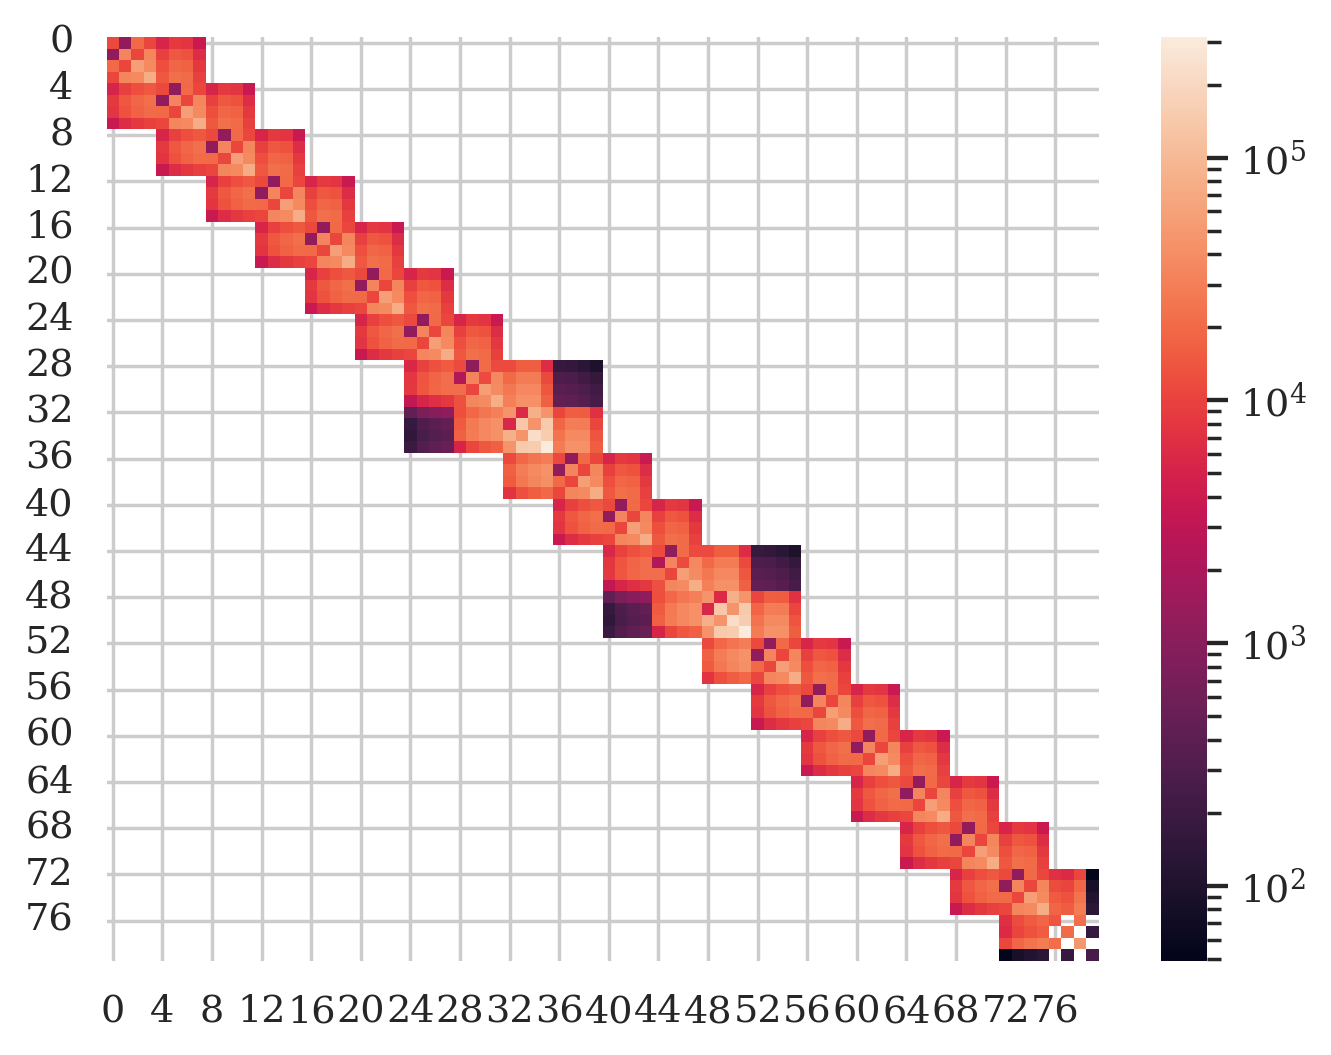

In [12]:
def get_mv(flux_type, local_matrices, bc, srd, p, grid, coarsen_M, redistribute_M):
    def mv(u):
        U = np.reshape(u, (grid.N, p+1))
        Q = compute_Q(U, grid, flux_type, local_matrices, bc)
        
        if srd:
            Q_SRD = Redistribute(Coarsen(Q, grid, p, coarsen_M), grid, p, redistribute_M) # Why only apply SRD to Q??
            """------ play around with parameters-------"""
            Q = Q * np.array([(grid.h_local / grid.h) ** (1)]).T + Q_SRD * np.array([1 - (grid.h_local / grid.h) ** (1)]).T 
            
        F = compute_F(U, Q, grid, flux_type, local_matrices, bc=bc)
        
        # if srd:
        #     F_SRD = Redistribute(Coarsen(F, grid, p, coarsen_M), grid, p, redistribute_M) # Why only apply SRD to Q??
        #     """------ play around with parameters-------"""
        #     F = F * np.array([(grid.h_local / grid.h) ** p]).T + F_SRD * np.array([1 - (grid.h_local / grid.h) ** p]).T 
                 
        return F.flatten()
    return mv

bc = [1, -1]
p = 3
N = 20
grid = Grid(L, N, [1/4, 1/4], [N//2-1, N//2+3])
grid.preprocess()
grid.find_local_basis(p)
coarsen_M = get_coarsen_M(p, grid)
redistribute_M = get_redistribute_M(p, grid)
local_matrices = load_local_matrices(p)
A = sp.LinearOperator( (N*(p+1), N*(p+1)), matvec=get_mv("LDG", local_matrices, bc, True, p, grid, coarsen_M, redistribute_M) )
b_hat = A * np.zeros(N*(p+1))

Adense = A * np.eye(N*(p+1)) - np.array([b_hat]).T
Adense[np.abs(Adense) < 1E-11] = 0
print("Condition number of A is:")
print(np.linalg.cond(Adense))
fig, ax = plt.subplots(dpi=250)
sns.heatmap(np.abs(Adense), norm=LogNorm(), ax=ax)
plt.show()

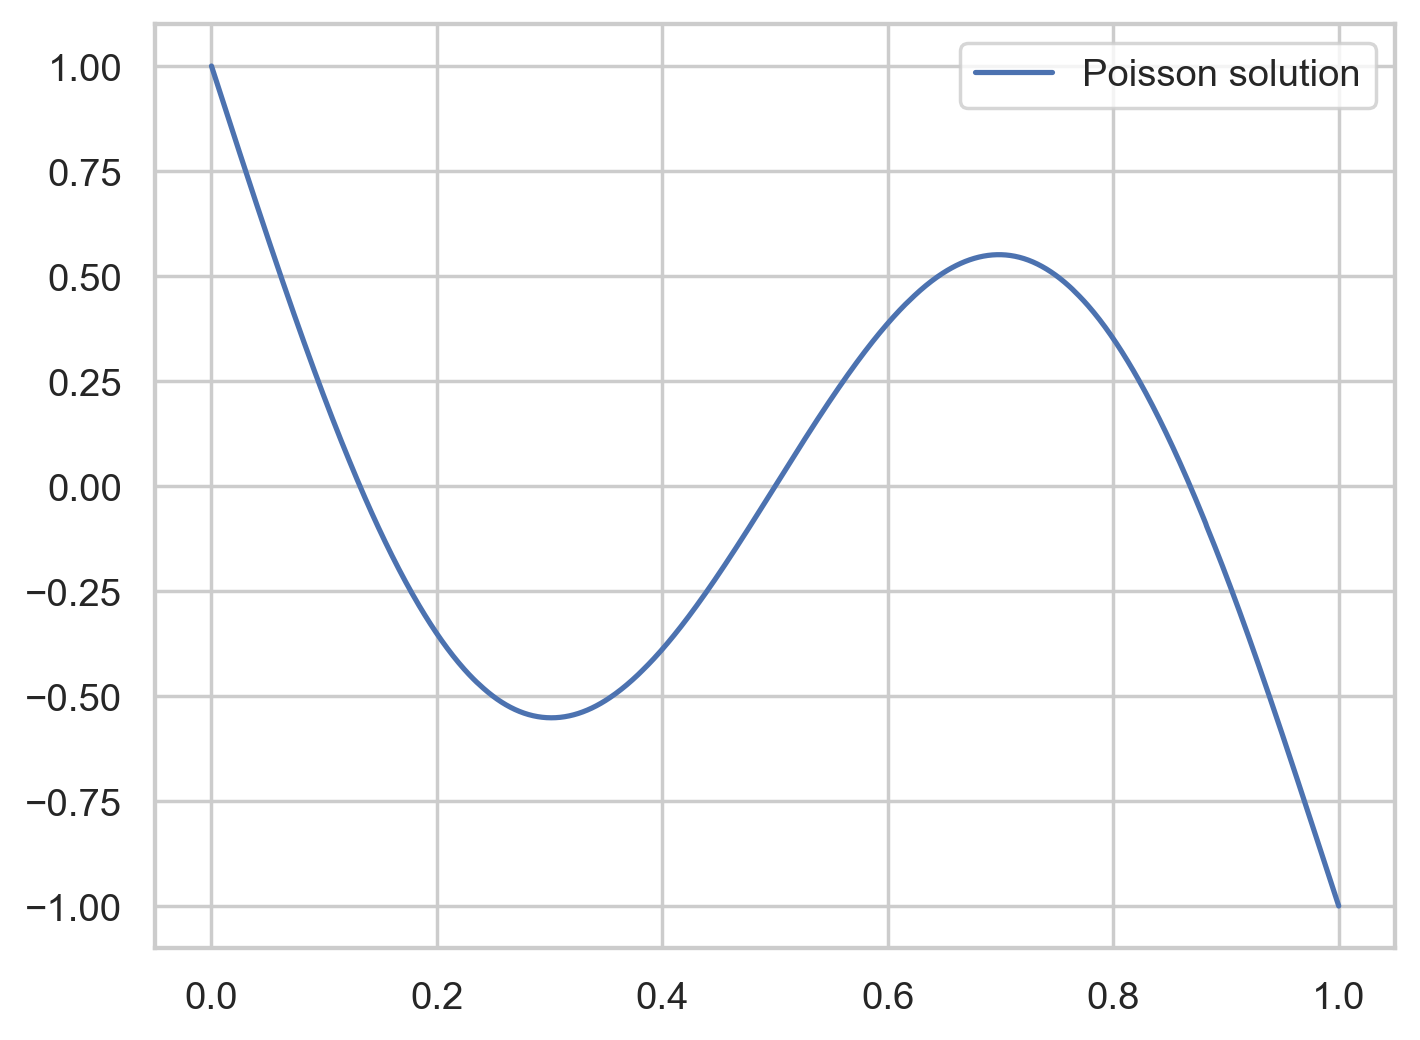

In [24]:
F = initialize(lambda x: (2*np.pi)**2 * np.sin(2*np.pi*x), grid, p)
F = F.flatten() - b_hat
U = np.linalg.solve(Adense, F)
U = np.reshape(U, (N, p+1))

func_U  = evaluate_sol(U, grid)
xs      = np.linspace(0, L, 1000)
us      = do_op(func_U, xs)
fig, ax = plt.subplots(dpi=250)
ax.plot(xs, us, label="Poisson solution")
ax.legend()
plt.show()

Condition number of A is:

38621.255444073824

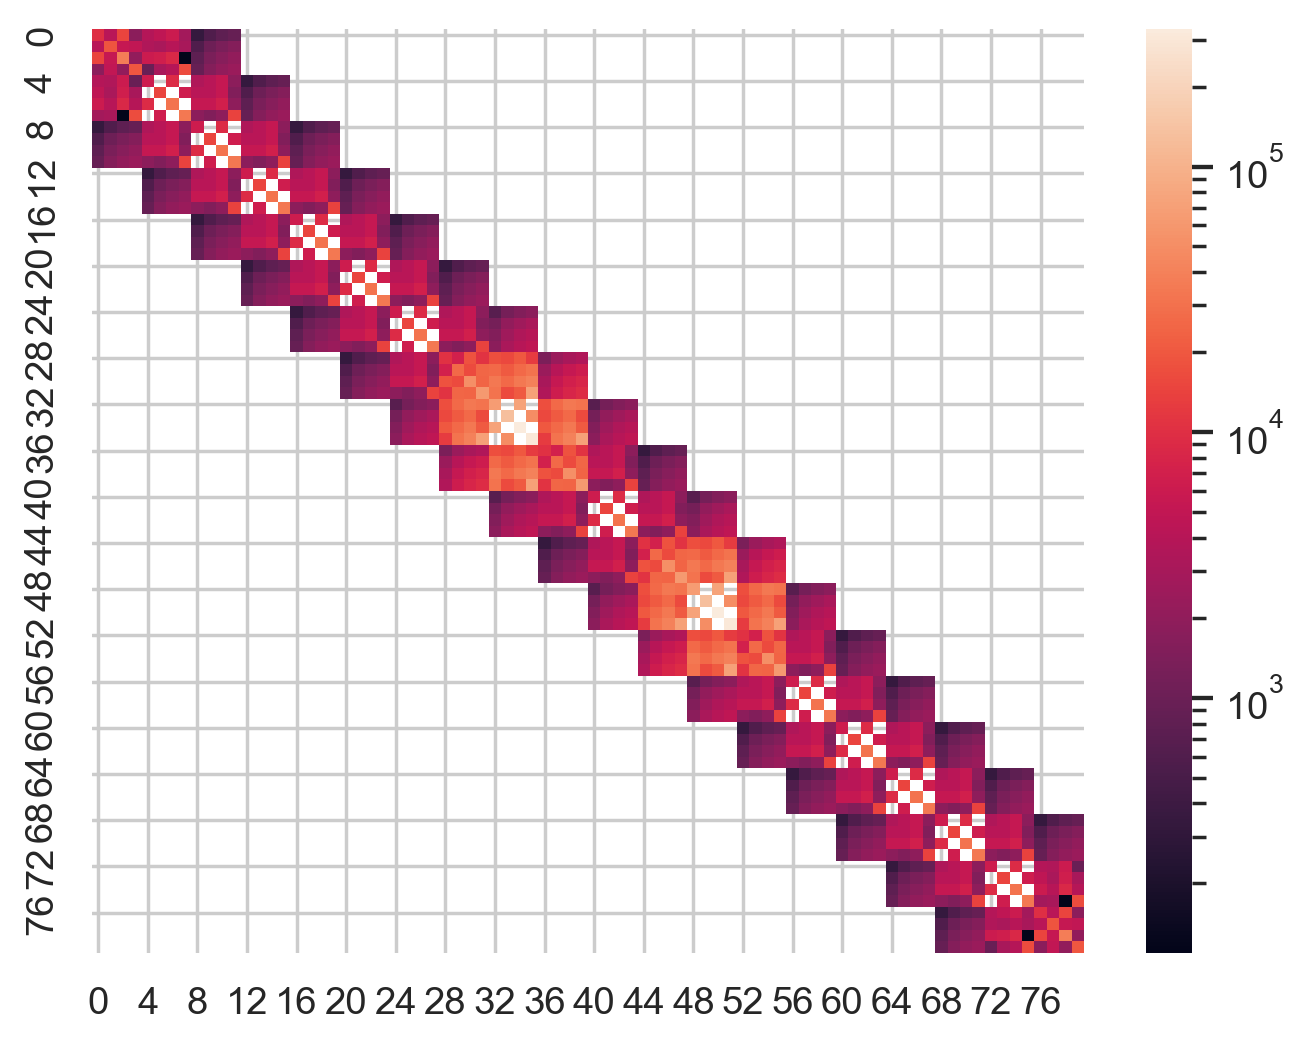

In [30]:
A = sp.LinearOperator((N*(p+1), N*(p+1)), matvec=get_mv("central", local_matrices, [0, 0], False, p, grid, coarsen_M, redistribute_M))
Adense = A * np.eye(N*(p+1))
Adense[np.abs(Adense) < 1E-10] = 0
print("Condition number of A is:")
print(np.linalg.cond(Adense))
fig, ax = plt.subplots(dpi=250)
sns.heatmap(np.abs(Adense), norm=LogNorm(), ax=ax)
plt.show()

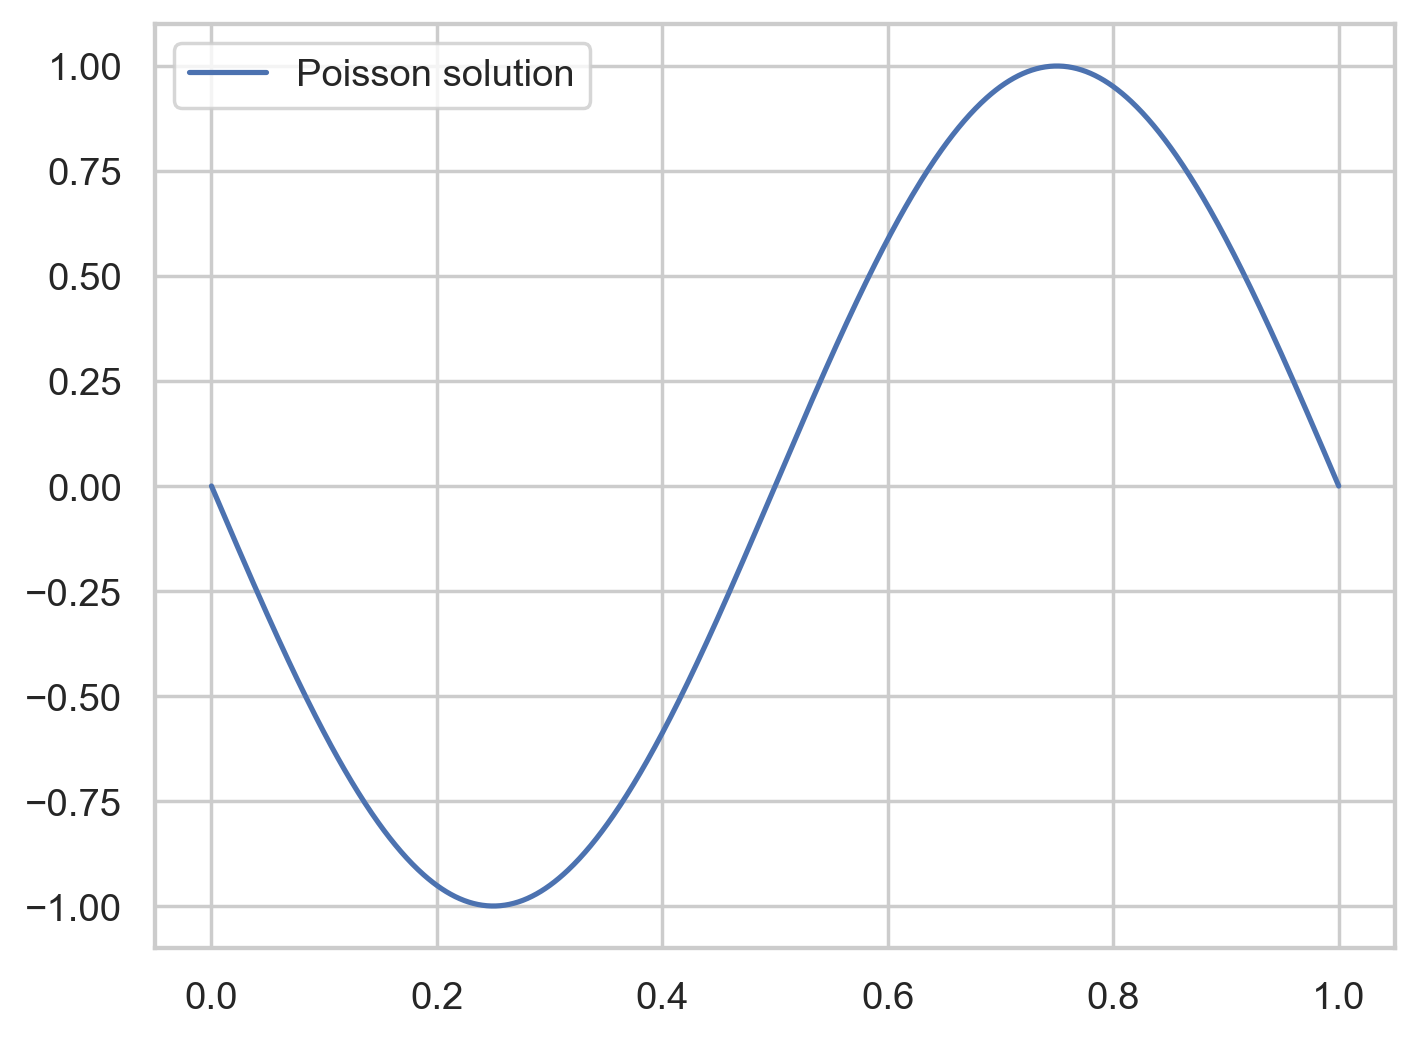

In [14]:
F = initialize(lambda x: (2*np.pi)**2 * np.sin(2*np.pi*x), grid, p)
F = F.flatten()
U = np.linalg.solve(Adense, F)
U = np.reshape(U, (N, p+1))

func_U  = evaluate_sol(U, grid)
xs      = np.linspace(0, L, 1000)
us      = do_op(func_U, xs)
fig, ax = plt.subplots(dpi=250)
ax.plot(xs, us, label="Poisson solution")
ax.legend()
plt.show()

Condition number of A is:

41401.53683099427

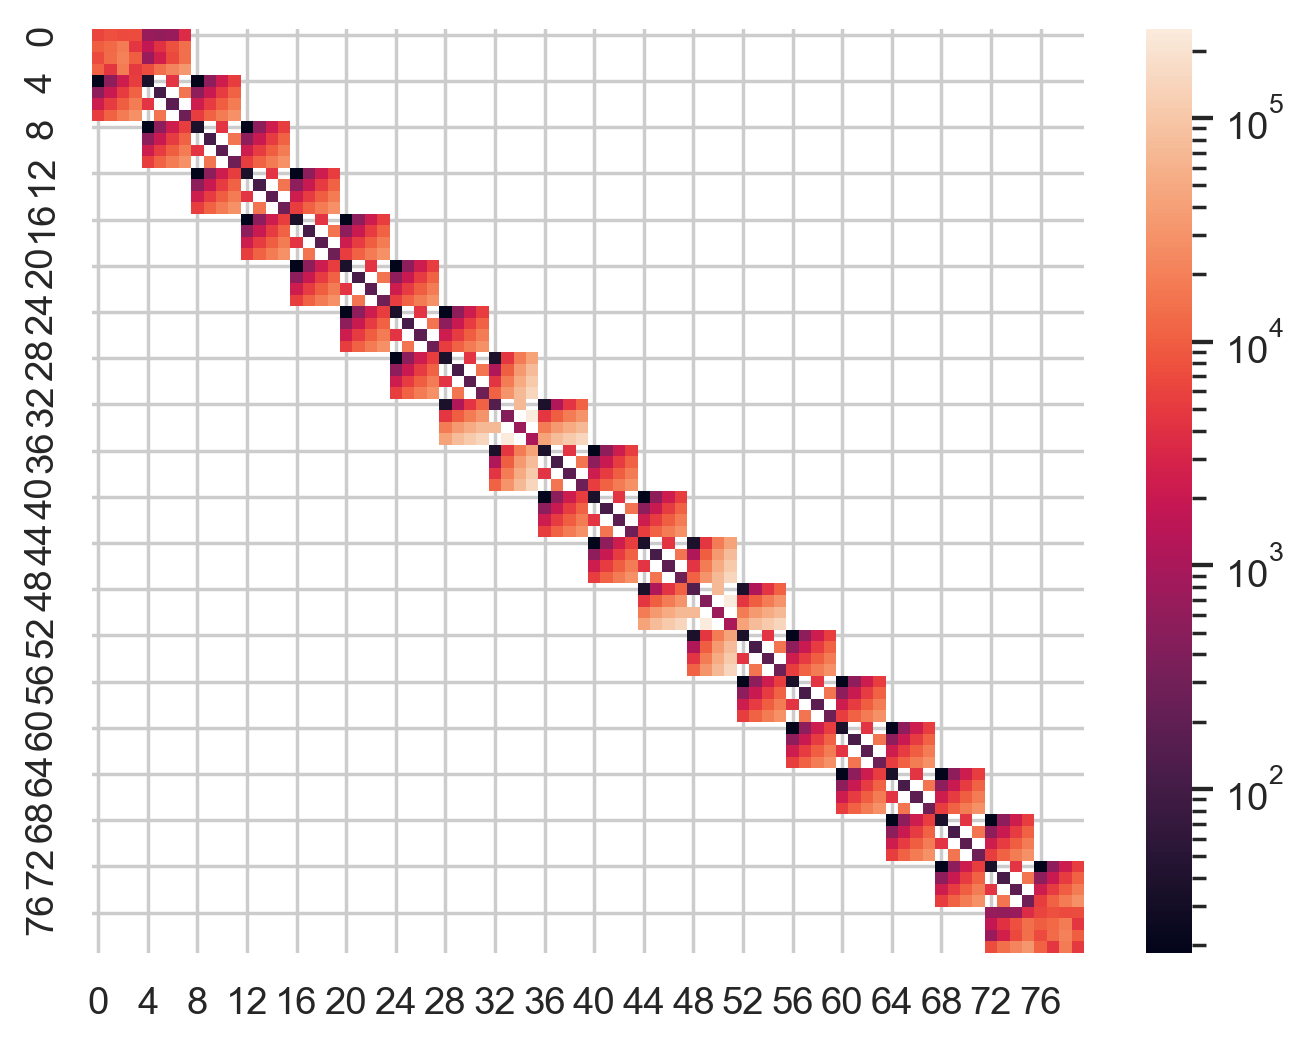

In [31]:
A = sp.LinearOperator((N*(p+1), N*(p+1)), matvec=get_mv("IP", local_matrices, [0, 0], False, p, grid, coarsen_M, redistribute_M))
Adense = A * np.eye(N*(p+1))
Adense[np.abs(Adense) < 1E-11] = 0
print("Condition number of A is:")
print(np.linalg.cond(Adense))
fig, ax = plt.subplots(dpi=250)
sns.heatmap(np.abs(Adense), norm=LogNorm(), ax=ax)
plt.show()

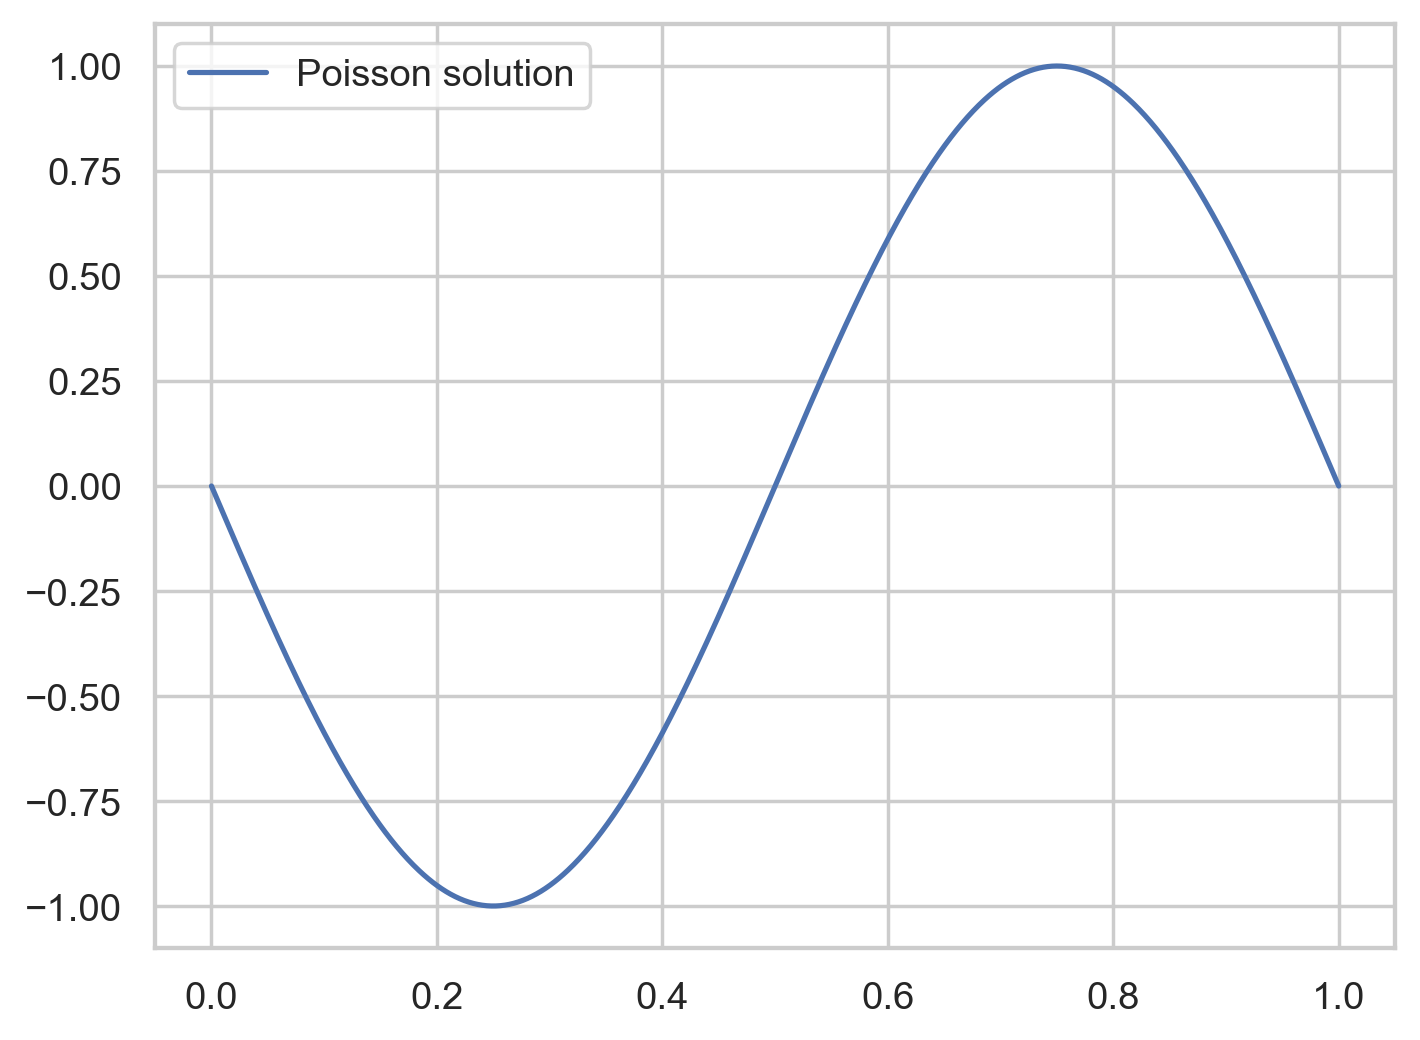

In [16]:
F = initialize(lambda x: (2*np.pi)**2 * np.sin(2*np.pi*x), grid, p)
F = F.flatten()
U = np.linalg.solve(Adense, F)
U = np.reshape(U, (N, p+1))

func_U  = evaluate_sol(U, grid)
xs      = np.linspace(0, L, 1000)
us      = do_op(func_U, xs)
fig, ax = plt.subplots(dpi=250)
ax.plot(xs, us, label="Poisson solution")
ax.legend()
plt.show()

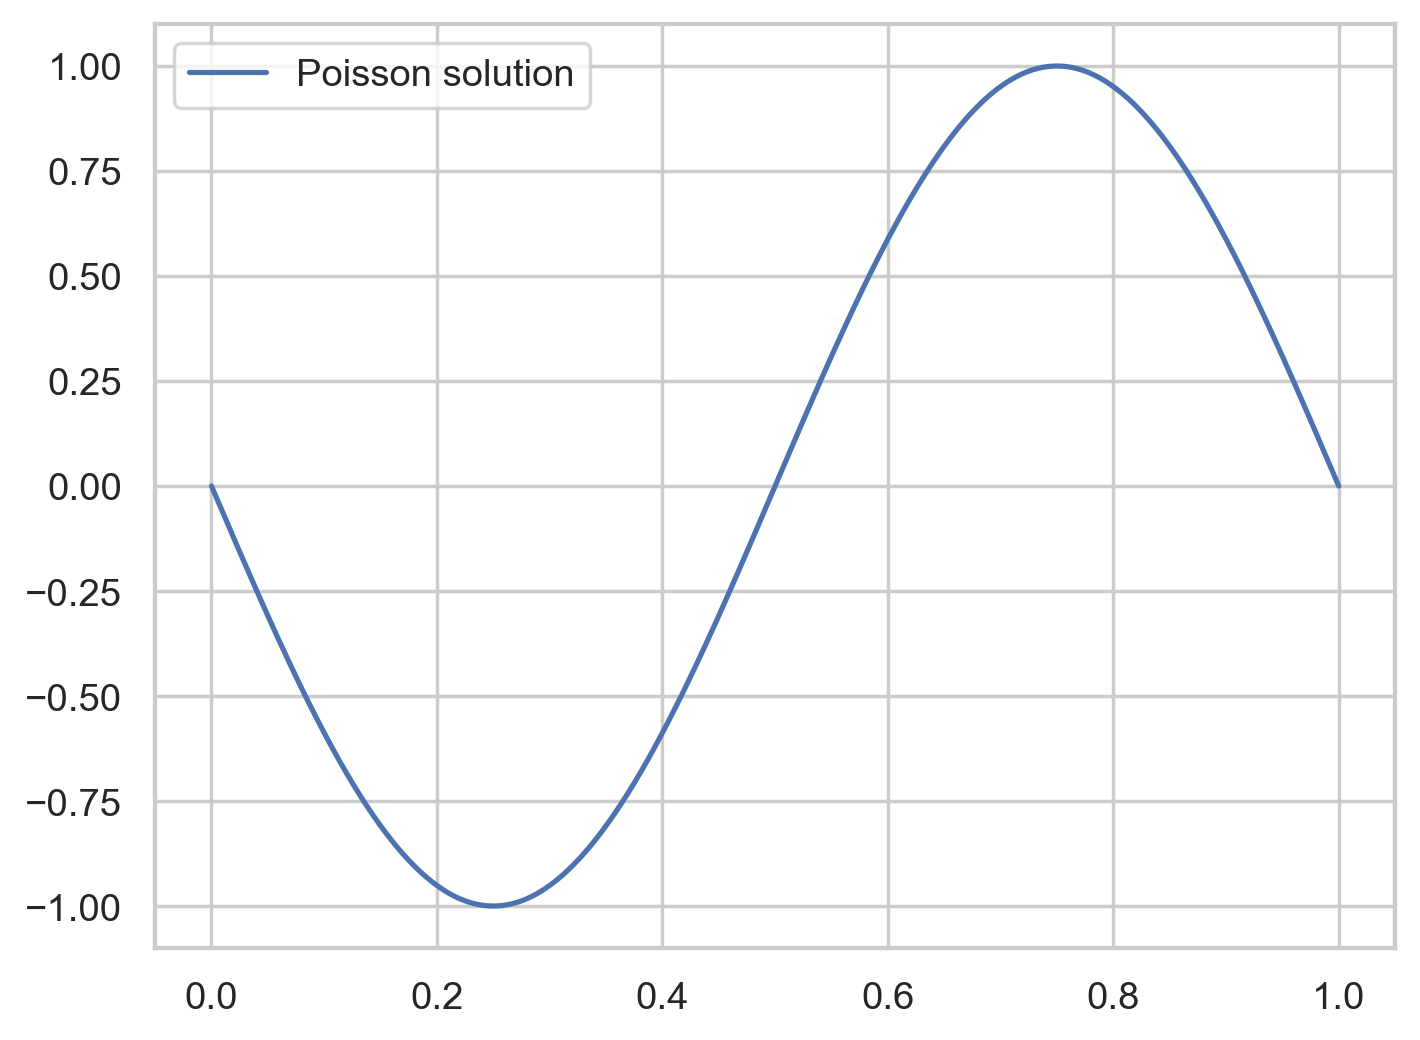

In [17]:
def solve_Poisson(L, N, alphas, positions, p, f, bc, srd=False, flux_type="LDG"):
    grid = Grid(L, N, alphas, positions)
    grid.preprocess()
    grid.find_local_basis(p)
    
    coarsen_M = get_coarsen_M(p, grid)
    redistribute_M = get_redistribute_M(p, grid)
        
    local_matrices = load_local_matrices(p)
    A = sp.LinearOperator((N*(p+1), N*(p+1)), matvec=get_mv(flux_type, local_matrices, bc, srd, p, grid, coarsen_M, redistribute_M))
    b_hat = A * np.zeros(N*(p+1))
    Adense = A * np.eye(N*(p+1)) - np.array([b_hat]).T
    F = initialize(f, grid, p)
    F = F.flatten() - b_hat
    U = np.linalg.solve(Adense, F)
    U = np.reshape(U, (N, p+1))

    return U, grid

U, grid = solve_Poisson(1.0, 10, [], [], 4, lambda x: (2*np.pi)**2 * np.sin(2*np.pi*x), [0, 0], False, "LDG")
func_U  = evaluate_sol(U, grid)
xs      = np.linspace(0, L, 1000)
us      = do_op(func_U, xs)
fig, ax = plt.subplots(dpi=250)
ax.plot(xs, us, label="Poisson solution")
ax.legend()
plt.show()

100%|██████████| 8/8 [00:11<00:00,  1.50s/it]
/var/folders/86/0dvym1n11pq3yfz2v0bcnv2h0000gn/T/ipykernel_38542/2686532010.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


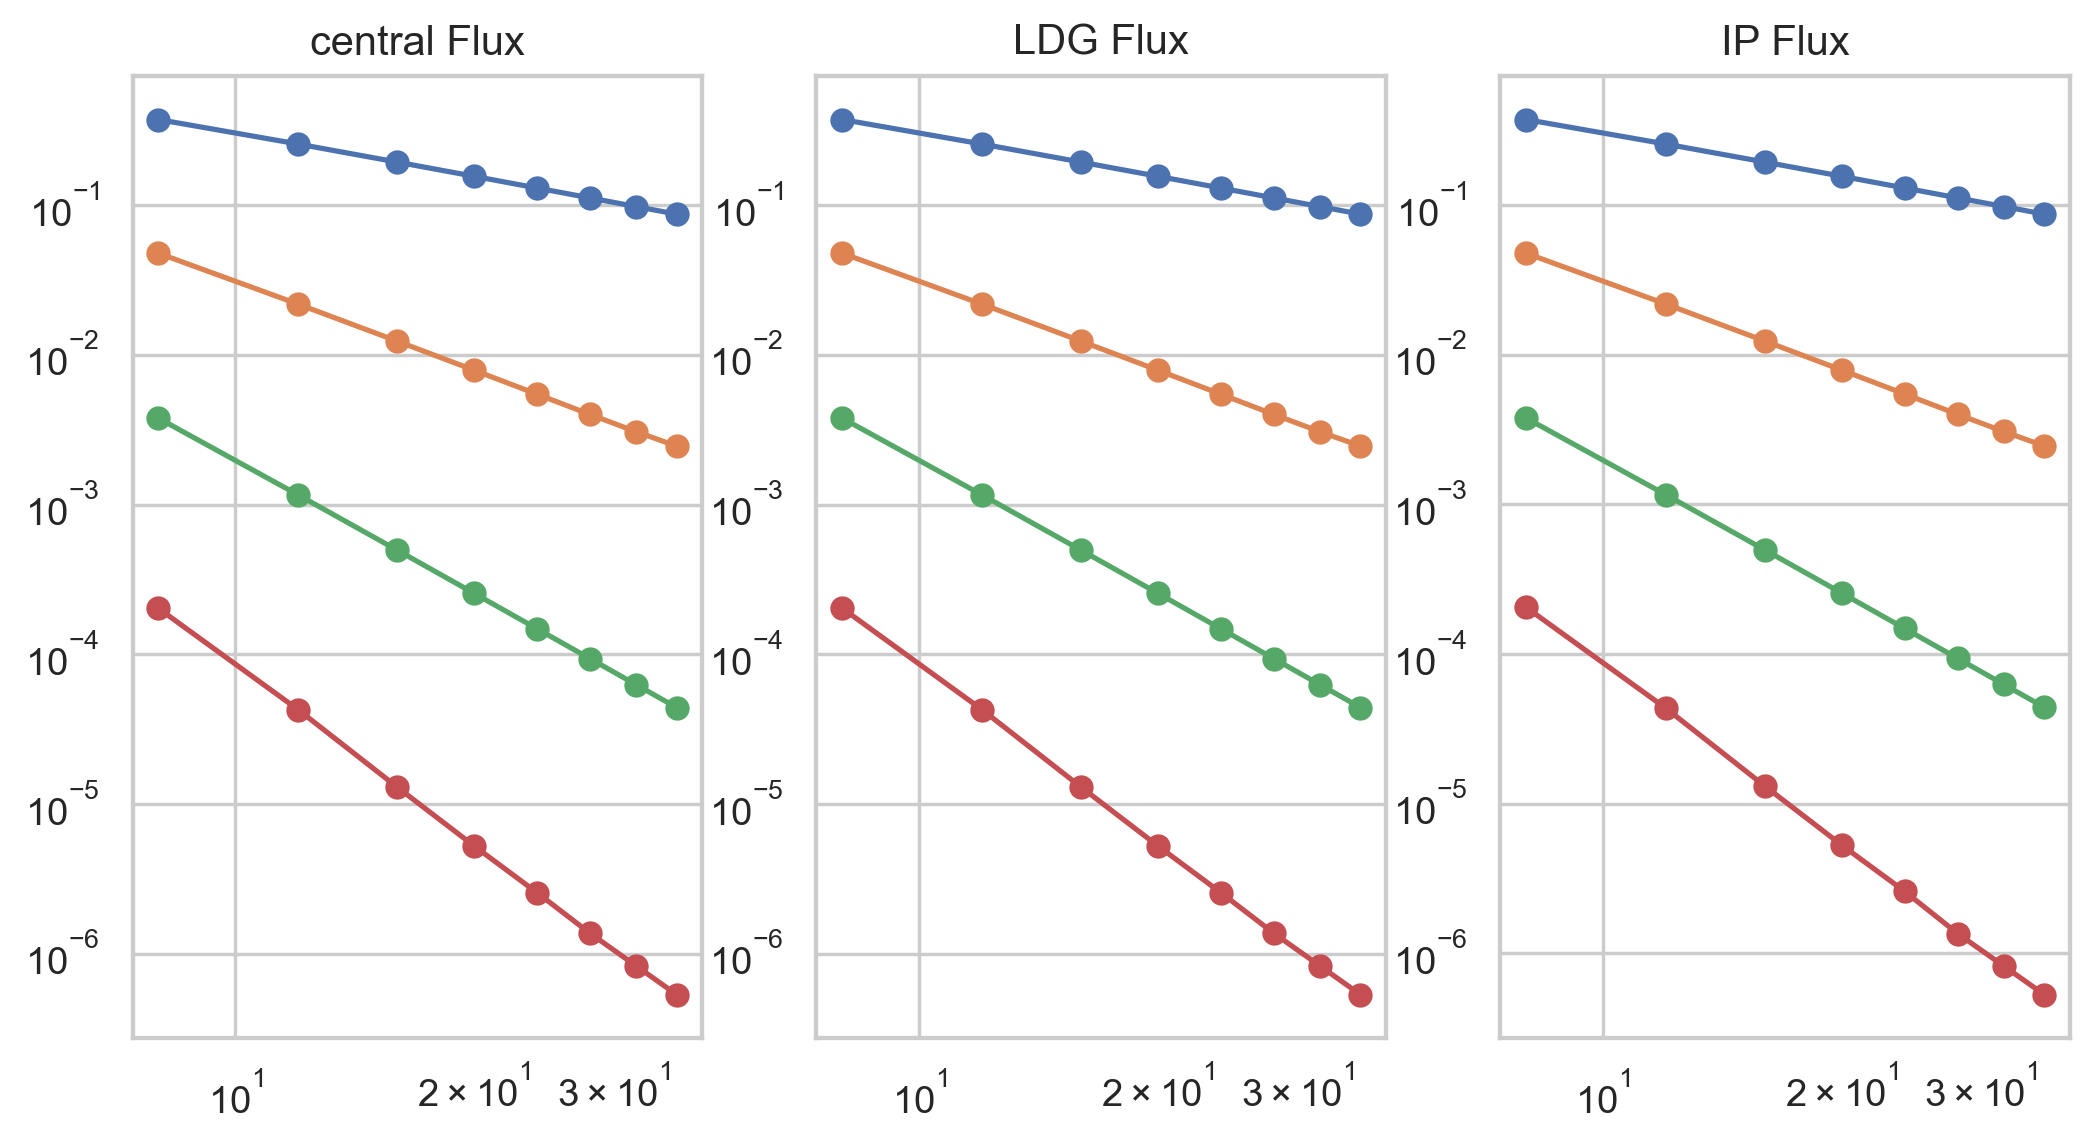

In [18]:
fig, ax = plt.subplots(1, 3, dpi=250, figsize=(10, 5))
fluxes = ["central", "LDG", "IP"]
for ff in range(3):
    flux = fluxes[ff]
    for p in range(4):
        errors = []
        for N in tqdm(np.arange(8, 40, 4)):
            U, grid = solve_Poisson(1.0, N, [], [], 4, lambda x: (2*np.pi)**2 * np.sin(2*np.pi*x), [0, 0], False, flux)
            func_U  = evaluate_sol(U, grid)
            xs      = np.linspace(0, L, 1000)
            us      = do_op(func_U, xs)
            true_us = - np.sin(2*np.pi*xs)
            errors.append(np.max(np.abs(us-true_us)))
        ax[ff].loglog(np.arange(8, 40, 4), errors, label=f"p={p}", marker="o")
        ax[ff].set_title(flux + " Flux")
fig.show()

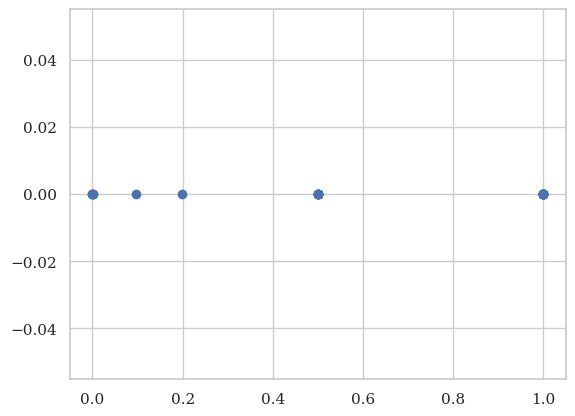

[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.65542713e-02 1.07968041e-04
 1.09097491e-07 1.00000000e+00 1.00000000e+00 1.00000000e+00
 5.00000000e-01 5.00000000e-01 5.00000000e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.97818785e-01 1.36986301e-03
 7.63038740e-06 1.00000000e+00 1.00000000e+00 1.00000000e+00
 5.00000000e-01 5.00000000e-01 5.00000000e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00]

9166113.643070312

In [20]:
def SRD_test(p, grid, coarsen_M, redistribute_M):
    def mv(u):
        U = np.reshape(u, (grid.N, p+1))
        U = Redistribute(Coarsen(U, grid, p, coarsen_M), grid, p, redistribute_M)
        # U = U * np.array([grid.h_local / grid.h]).T + U_SRD * np.array([1 - grid.h_local / grid.h]).T
        return U.flatten()
    return mv

p = 2
N = 10
grid = Grid(L, N, [1/10, 1/4], [N//2-1, N//2+3])
grid.preprocess(merge_type="central")
grid.find_local_basis(p)

coarsen_M = get_coarsen_M(p, grid)
redistribute_M = get_redistribute_M(p, grid)
    
local_matrices = load_local_matrices(p)
A = sp.LinearOperator((N*(p+1), N*(p+1)), matvec=SRD_test(p, grid, coarsen_M, redistribute_M))
Adense = A * np.eye(N*(p+1))
eig_val, eig_vec = np.linalg.eig(Adense)
plt.scatter(np.real(eig_val), np.imag(eig_val))
plt.show()
print(eig_val)
print(np.linalg.cond(Adense))

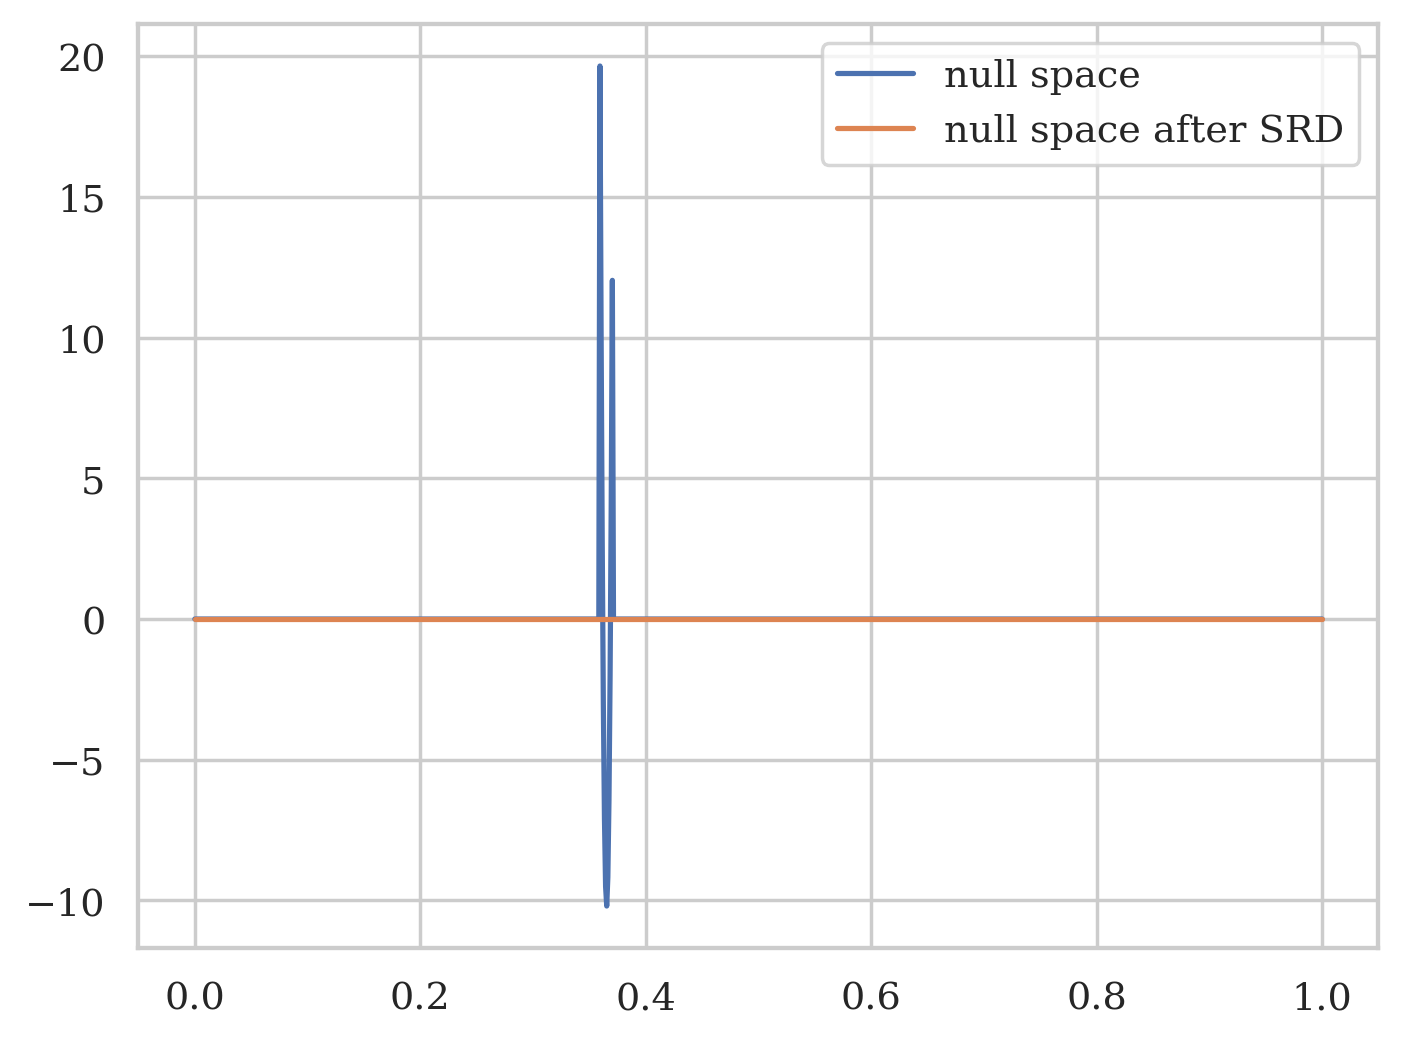

In [21]:
U = eig_vec[:, np.argmin(np.abs(eig_val))]
U = np.reshape(U, (N, p+1))
V = Redistribute(Coarsen(U, grid, p, coarsen_M), grid, p, redistribute_M)
func_U  = evaluate_sol(U, grid)
xs      = np.linspace(0, L, 1000)
us      = do_op(func_U, xs)
func_V  = evaluate_sol(V, grid)
xs      = np.linspace(0, L, 1000)
vs      = do_op(func_V, xs)
fig, ax = plt.subplots(dpi=250)
ax.plot(xs, us, label="null space")
ax.plot(xs, vs, label="null space after SRD")
ax.legend()
plt.show()

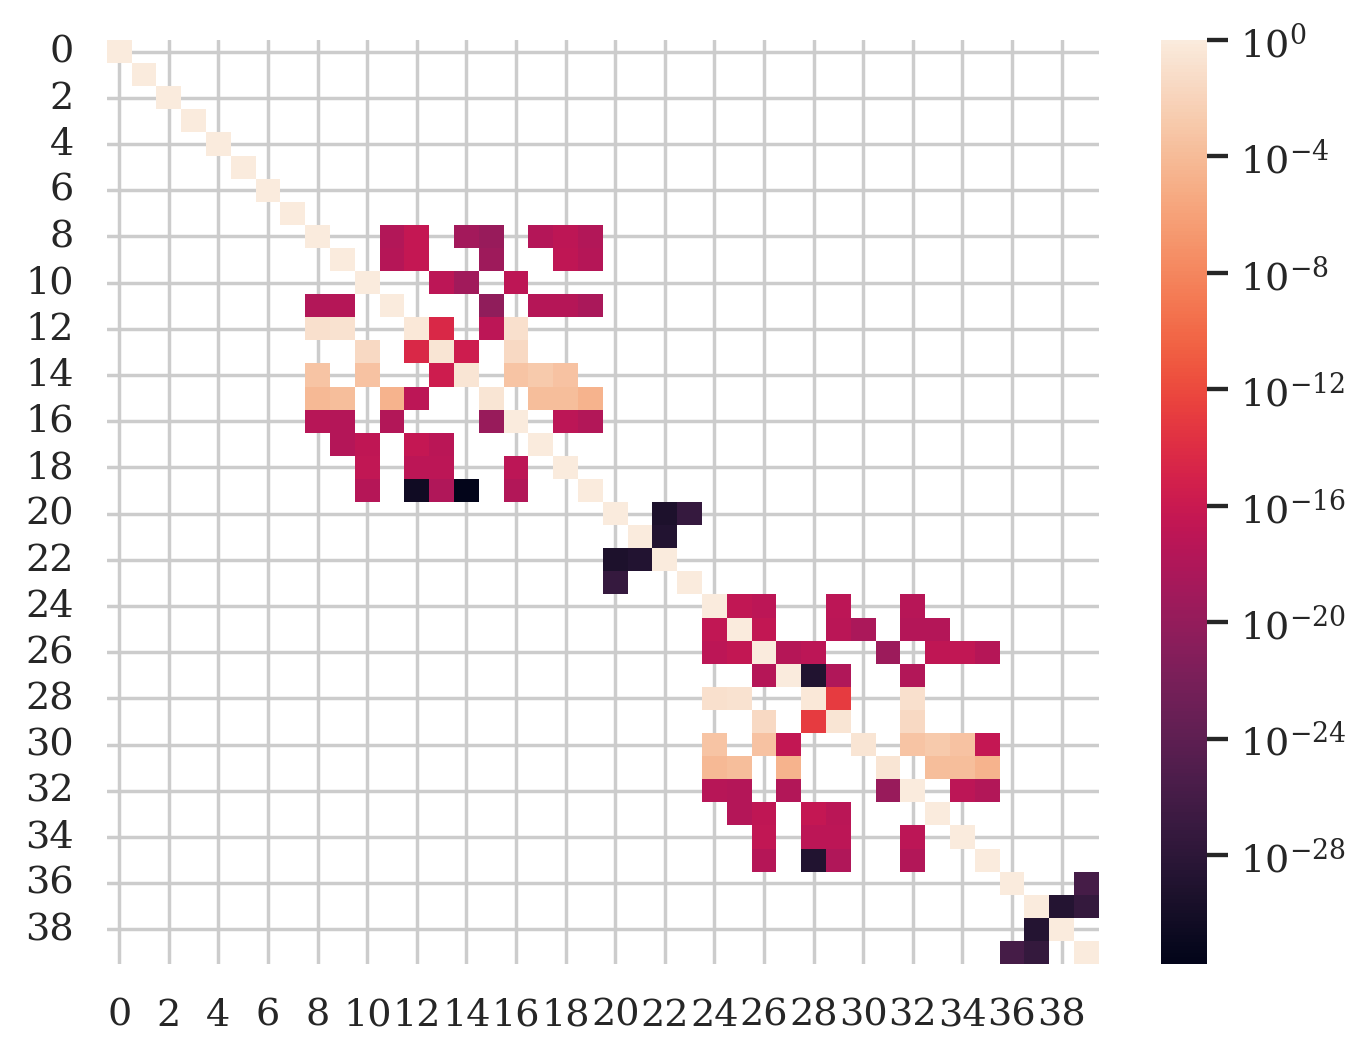

In [15]:
fig, ax = plt.subplots(dpi=250)
sns.heatmap(Adense, norm=LogNorm(), ax=ax)
plt.show()